Dự đoán Volatility (Predicted Vol)
Dùng một mô hình GARCH(1,1) để dự đoán volatility của thị trường cho ngày hôm sau.

Xác định chế độ thị trường (Regime Switching) dựa vào một ngưỡng Threshold:

Nếu Predicted Volatility > Threshold → thị trường biến động cao → dùng chiến lược Mean Reversion (RSI).

Nếu Predicted Volatility ≤ Threshold → thị trường biến động thấp → dùng chiến lược Momentum (SMA Crossover).

Chiến lược trong từng Regime:

Regime Biến động Cao → Mean Reversion (RSI)
RSI thấp → mua
RSI cao → bán

Regime Biến động Thấp → Momentum (SMA Crossover)
SMA ngắn cắt lên SMA dài → mua
SMA ngắn cắt xuống → bán

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import pandas as pd
import numpy as np
import processing_data as pr
import feature_engineer as fe 
import data_generator as dg
import detect_and_handle_outlier as outlier
import matplotlib.pyplot as plt
from arch import arch_model


In [5]:
csv_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\stocks_data\AAPL.csv"
SP_500_path = r"C:\Users\ADMIN\Documents\Quantitative\Data\S&P_500"
df_SP500 = pd.read_csv(SP_500_path)
df = pr.load_data(csv_path)
df

,date,ticker,adj_close,close,high,low,open,volume
0,2015-01-02,AAPL,24.237545,27.332500,27.860001,26.837500,27.847500,212818400.0
1,2015-01-05,AAPL,23.554737,26.562500,27.162500,26.352501,27.072500,257142000.0
2,2015-01-06,AAPL,23.556955,26.565001,26.857500,26.157499,26.635000,263188400.0
3,2015-01-07,AAPL,23.887274,26.937500,27.049999,26.674999,26.799999,160423600.0
4,2015-01-08,AAPL,24.805080,27.972500,28.037500,27.174999,27.307501,237458000.0
...,...,...,...,...,...,...,...,...
2697,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0
2698,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0
2699,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0
2700,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0


In [6]:
df_SP500['date'] = pd.to_datetime(df_SP500['date'])

In [7]:
df_SP500 = fe.add_lagged_log_returns(df_SP500, "close", no_max_lags=0)
df_SP500

,date,ticker,close,high,low,open,volume,close_log_return
0,2015-01-02,^GSPC,2058.199951,2072.360107,2046.040039,2058.899902,2708700000,NaN
1,2015-01-05,^GSPC,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2,2015-01-06,^GSPC,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
3,2015-01-07,^GSPC,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
4,2015-01-08,^GSPC,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
...,...,...,...,...,...,...,...,...
2697,2025-09-24,^GSPC,6637.970215,6672.660156,6621.759766,6669.790039,5459180000,-0.002851
2698,2025-09-25,^GSPC,6604.720215,6619.000000,6569.220215,6608.189941,5874670000,-0.005022
2699,2025-09-26,^GSPC,6643.700195,6648.970215,6604.430176,6615.379883,5103110000,0.005884
2700,2025-09-29,^GSPC,6661.209961,6677.310059,6644.490234,6661.580078,5358760000,0.002632


#### Preprocesing Data

- Sort & deduplicate
- Check OHLCV sanity
- Check missing value

In [8]:
df = pr.sort_and_deduplicate(df)
df_bad = pr.check_ohlcv_sanity(df)
df_bad

,date,ticker,adj_close,close,high,low,open,volume


In [9]:
pr.check_missing_values(df)

No Missing value


In [10]:
# add close log return and features
features = ["MA_50", "RSI_14"]

df = fe.add_lagged_log_returns(df, "close", no_max_lags=0).dropna().reset_index(drop=True)
df = fe.add_features(df,features_pool=features).dropna().reset_index(drop=True)
df["close_log_return_pct"] = df["close_log_return"]*100
df

,date,ticker,adj_close,close,high,low,open,volume,close_log_return,MA_50,RSI_14,close_log_return_pct
0,2015-03-18,AAPL,28.593136,32.117500,32.290001,31.592501,31.750000,261083600.0,0.011193,30.003150,45.533452,1.119342
1,2015-03-19,AAPL,28.377245,31.875000,32.312500,31.850000,32.187500,183238000.0,-0.007579,30.114250,44.971639,-0.757906
2,2015-03-20,AAPL,28.021137,31.475000,32.099998,31.290001,32.062500,274780400.0,-0.012628,30.220450,47.391285,-1.262841
3,2015-03-23,AAPL,28.312698,31.802500,31.962500,31.629999,31.780001,150838800.0,0.010351,30.311200,41.765631,1.035130
4,2015-03-24,AAPL,28.196960,31.672501,32.009998,31.639999,31.807501,131369200.0,-0.004096,30.387800,44.732969,-0.409608
...,...,...,...,...,...,...,...,...,...,...,...,...
2646,2025-09-24,AAPL,252.065643,252.309998,255.740005,251.039993,255.220001,42303700.0,-0.008367,225.743600,66.814153,-0.836724
2647,2025-09-25,AAPL,256.621216,256.869995,257.170013,251.710007,253.210007,55202100.0,0.017912,226.607599,62.979078,1.791162
2648,2025-09-26,AAPL,255.212601,255.460007,257.600006,253.779999,254.100006,46076300.0,-0.005504,227.541799,66.287444,-0.550423
2649,2025-09-29,AAPL,254.183594,254.429993,255.000000,253.009995,254.559998,40127700.0,-0.004040,228.450599,66.794047,-0.404015


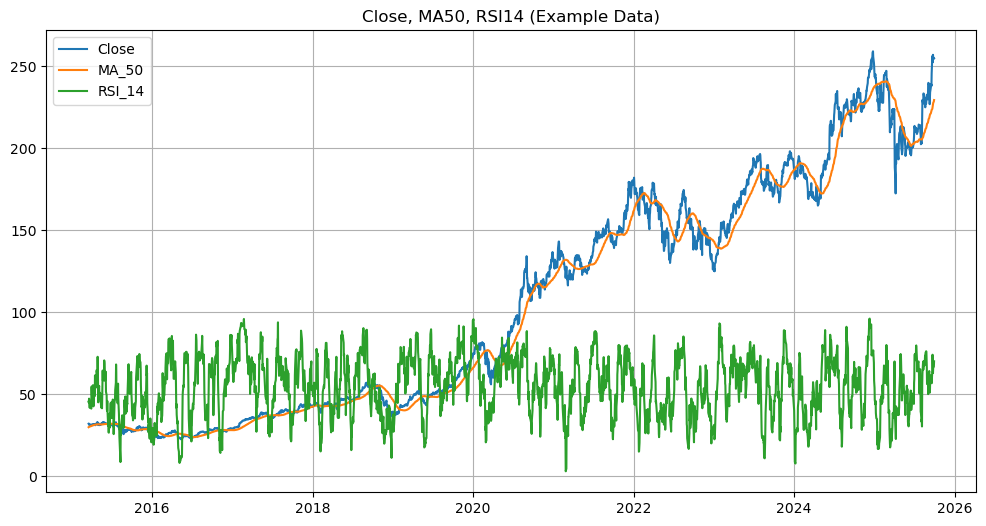

In [11]:
plt.figure(figsize=(12,6))
plt.plot(df["date"], df["close"], label="Close")
plt.plot(df["date"], df["MA_50"], label="MA_50")
plt.plot(df["date"], df["RSI_14"], label="RSI_14")
plt.legend()
plt.grid(True)
plt.title("Close, MA50, RSI14 (Example Data)")
plt.show()

In [12]:
# Handle outlier 
df = outlier.winsorize(df, "close_log_return_pct")

In [13]:
window_size = 252
forecast_vol = []

for i in range(window_size,len(df)):
    train_returns = df['close_log_return_pct'].iloc[i-window_size:i]

    model = arch_model(train_returns, vol='Garch', p=1, q=1, mean='Zero', rescale=False)
    res = model.fit(disp='off')

    # Dự báo variance cho t+1
    forecast = res.forecast(horizon=1)
    var_next = forecast.variance.iloc[-1, 0]

    # Lưu Volatility (Std Dev)
    forecast_vol.append(np.sqrt(var_next))

In [14]:
trade_results = df.iloc[window_size:].copy()
trade_results['garch_vol'] = forecast_vol

In [15]:
# Momentum signals
trade_results['signal_momentum'] = np.where(trade_results['close'] > trade_results['MA_50'], 1, -1)

# Mean-Reversion signals
trade_results.loc[trade_results['RSI_14'] < 30, 'signal_mean_rev'] = 1
trade_results.loc[trade_results['RSI_14'] > 70, 'signal_mean_rev'] = -1
trade_results['signal_mean_rev'] = trade_results['signal_mean_rev'].replace(0, method='ffill').fillna(0)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10312\1479402650.py:7: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  trade_results['signal_mean_rev'] = trade_results['signal_mean_rev'].replace(0, method='ffill').fillna(0)


In [16]:
trade_results['vol_threshold'] = trade_results['garch_vol'].rolling(63).mean().shift(1)

In [17]:
trade_results['final_signal'] = np.where(
    trade_results['garch_vol'] > trade_results['vol_threshold'],
    trade_results['signal_mean_rev'], 
    trade_results['signal_momentum']  
)

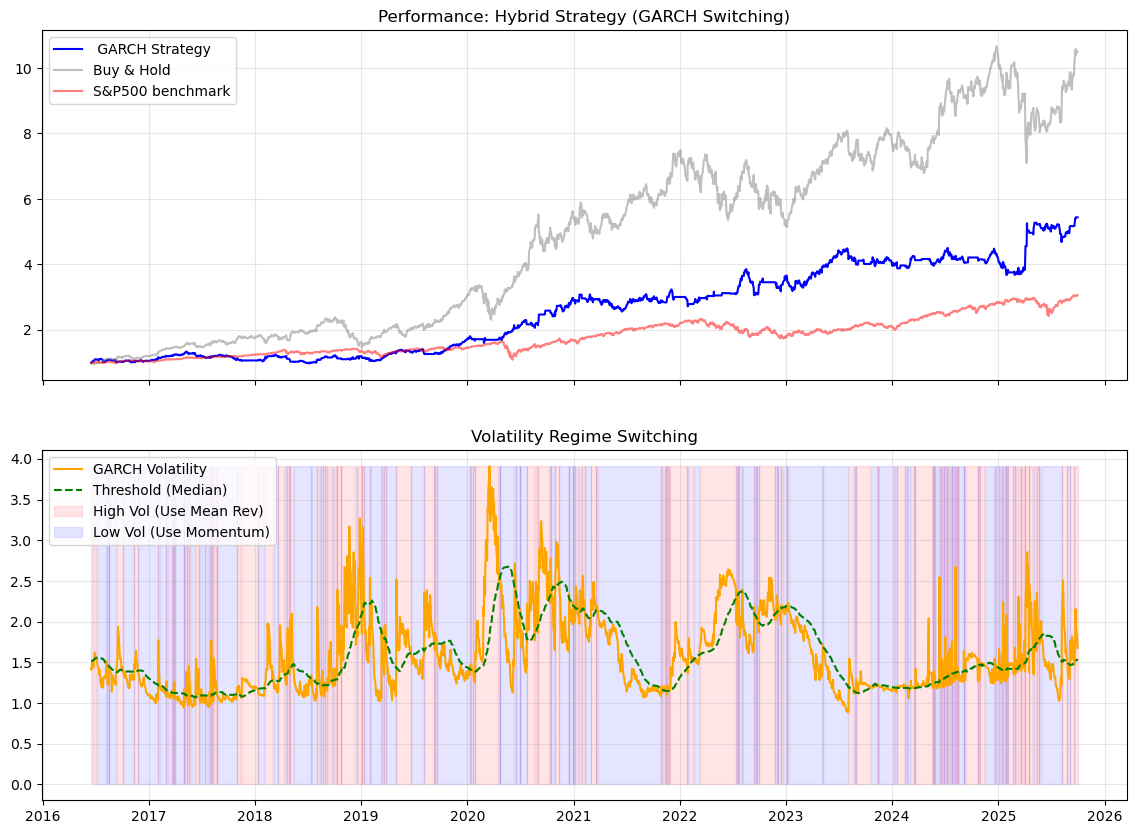

In [18]:
trade_results['trade_log_return'] = trade_results['final_signal'].shift(1) * trade_results['close_log_return']
trade_results.dropna(inplace=True)

# Cumulative Returns
trade_results['cum_S&P500'] = np.exp(df_SP500['close_log_return'].cumsum())
trade_results['cum_strategy'] = np.exp(trade_results['trade_log_return'].cumsum())
trade_results['cum_benchmark'] = np.exp(trade_results['close_log_return'].cumsum())

# Vẽ biểu đồ
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Biểu đồ 1: Hiệu suất
ax1.plot(trade_results['date'], trade_results['cum_strategy'], label=' GARCH Strategy', color='blue')
ax1.plot(trade_results['date'], trade_results['cum_benchmark'], label='Buy & Hold', color='gray', alpha=0.5)
ax1.plot(trade_results['date'], trade_results['cum_S&P500'], label='S&P500 benchmark', color='red', alpha=0.5)
ax1.set_title('Performance: Hybrid Strategy (GARCH Switching)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Biểu đồ 2: Chế độ Volatility
ax2.plot(trade_results['date'], trade_results['garch_vol'], label='GARCH Volatility', color='orange')
ax2.plot(trade_results['date'], trade_results['vol_threshold'], label='Threshold (Median)', color='green', linestyle='--')
ax2.fill_between(trade_results['date'], 0, max(trade_results['garch_vol']),
                 where=trade_results['garch_vol'] > trade_results['vol_threshold'],
                 color='red', alpha=0.1, label='High Vol (Use Mean Rev)')
ax2.fill_between(trade_results['date'], 0, max(trade_results['garch_vol']),
                 where=trade_results['garch_vol'] <= trade_results['vol_threshold'],
                 color='blue', alpha=0.1, label='Low Vol (Use Momentum)')
ax2.set_title('Volatility Regime Switching')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.show()


In [19]:
import math

trade_results["is_won"] = np.where(np.sign(trade_results["final_signal"]) == np.sign(trade_results["close_log_return"]), 1, 0)

strategy_metrics = {
    "Win Rate": trade_results["is_won"].mean(),
    "Mean Log Return": trade_results["trade_log_return"].mean(),
    "Std Log Return": trade_results["trade_log_return"].std(),
    "Max Log Drawdown": (trade_results["cum_strategy"] - trade_results["cum_strategy"].cummax()).min(),
    "Sharpe Ratio": (trade_results["trade_log_return"].mean() / trade_results["trade_log_return"].std()) * math.sqrt(252)
}

# Metrics BENCHMARK (S&P 500)
sp500_log_ret = df_SP500["close_log_return"]
sp500_cum_ret = sp500_log_ret.cumsum()

benchmark_metrics = {
    # Win rate của thị trường là tỷ lệ số ngày tăng giá
    "Win Rate": (sp500_log_ret > 0).mean(),
    
    "Mean Log Return": sp500_log_ret.mean(),
    "Std Log Return": sp500_log_ret.std(),
    
    # Tính Drawdown cho Benchmark
    "Max Log Drawdown": (sp500_cum_ret - sp500_cum_ret.cummax()).min(),
    
    # Sharpe Ratio (Annualized)
    "Sharpe Ratio": (sp500_log_ret.mean() / sp500_log_ret.std()) * math.sqrt(252)
}

In [20]:
#  Create DataFrame
comparison_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=["Strategy", "S&P 500"])

# Transpose 
comparison_df = comparison_df.T

print(comparison_df)

                  Strategy   S&P 500
Win Rate          0.378853  0.539230
Mean Log Return   0.000725  0.000436
Std Log Return    0.013549  0.011380
Max Log Drawdown -0.828394 -0.414379
Sharpe Ratio      0.849397  0.608676


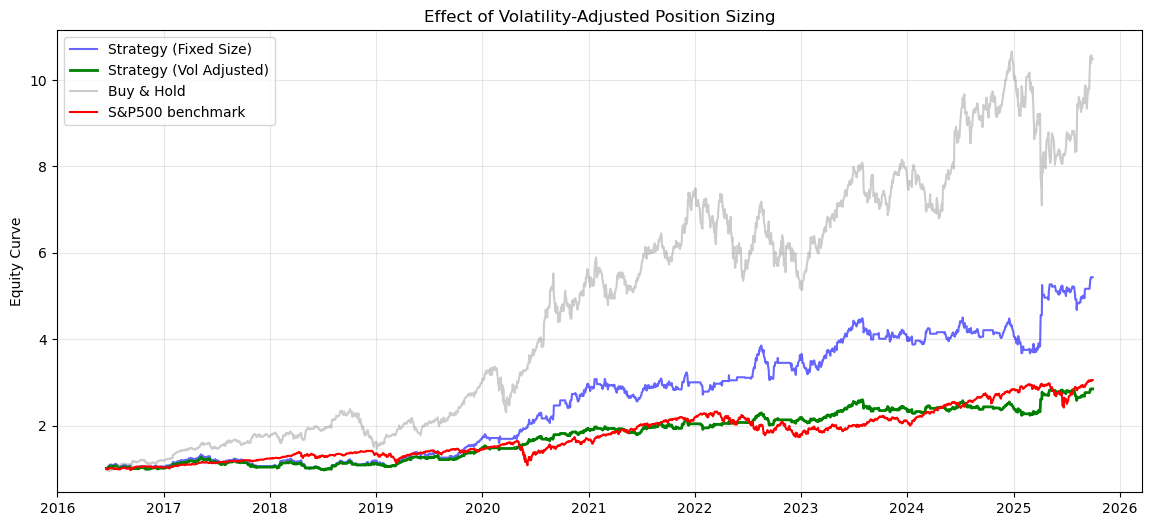

Sharpe Ratio (Fixed Size): 0.85
Sharpe Ratio (Vol Adjusted): 0.82


In [21]:
# --- 4. VOLATILITY-ADJUSTED POSITION SIZING (Target Volatility) ---


TARGET_VOL_ANNUAL = 0.15

target_vol_daily = TARGET_VOL_ANNUAL / np.sqrt(252) 


predicted_vol_decimal = trade_results['garch_vol'] / 100


trade_results['position_size'] = target_vol_daily / predicted_vol_decimal

MAX_LEVERAGE = 2.0
trade_results['position_size'] = trade_results['position_size'].clip(upper=MAX_LEVERAGE)

trade_results['scaled_signal'] = trade_results['final_signal'] * trade_results['position_size']

# --- 5. BACKTEST LẠI VỚI POSITION SIZING ---

trade_results['strategy_ret_vol_adj'] = trade_results['scaled_signal'].shift(1) * trade_results['close_log_return']
trade_results.dropna(inplace=True)

# Cumulative Returns
trade_results['cum_strategy_adj'] = np.exp(trade_results['strategy_ret_vol_adj'].cumsum())

# Vẽ biểu đồ so sánh
plt.figure(figsize=(14, 6))
plt.plot(trade_results['date'], trade_results['cum_strategy'], label='Strategy (Fixed Size)', color='blue', alpha=0.6)
plt.plot(trade_results['date'], trade_results['cum_strategy_adj'], label='Strategy (Vol Adjusted)', color='green', linewidth=2)
plt.plot(trade_results['date'], trade_results['cum_benchmark'], label='Buy & Hold', color='gray', alpha=0.4)
plt.plot(trade_results['date'], trade_results['cum_S&P500'], label='S&P500 benchmark', color='red')

plt.title('Effect of Volatility-Adjusted Position Sizing')
plt.ylabel('Equity Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

def quick_sharpe(ret_series):
    return (ret_series.mean() / ret_series.std()) * np.sqrt(252)

sharpe_fixed = quick_sharpe(trade_results['trade_log_return'])
sharpe_adj = quick_sharpe(trade_results['strategy_ret_vol_adj'])

print(f"Sharpe Ratio (Fixed Size): {sharpe_fixed:.2f}")
print(f"Sharpe Ratio (Vol Adjusted): {sharpe_adj:.2f}")